WTA data from Kaggle - 2000 to 2016

In [1]:
import time
import numpy as np
import pandas as pd
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn import ensemble
from sklearn import svm
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import math
import matplotlib.ticker as plticker
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics 
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [2]:
df = pd.read_csv('combined.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36456 entries, 0 to 36455
Data columns (total 49 columns):
best_of               36456 non-null int64
draw_size             36456 non-null int64
l_1stIn               19768 non-null float64
l_1stWon              19768 non-null float64
l_2ndWon              19768 non-null float64
l_SvGms               103 non-null float64
l_ace                 19761 non-null float64
l_bpFaced             19766 non-null float64
l_bpSaved             19766 non-null float64
l_df                  19732 non-null float64
l_svpt                19767 non-null float64
loser_age             36452 non-null float64
loser_entry           7524 non-null object
loser_hand            35825 non-null object
loser_ht              22367 non-null float64
loser_id              36456 non-null int64
loser_ioc             36456 non-null object
loser_name            36456 non-null object
loser_rank            34773 non-null float64
loser_rank_points     34773 non-null float64
lose

In [4]:
df = df.drop(columns=["tourney_date", "match_num", "winner_id", "winner_seed", "tourney_level", "winner_ioc",\
                                    "winner_rank_points", "winner_entry","winner_name", "loser_id", "loser_seed", "loser_rank_points", "loser_entry", "loser_ioc",\
                                    "score", "round", "loser_name", "minutes","surface", "winner_hand", "winner_ht", "winner_age", "winner_rank", "loser_hand", "loser_ht",\
                                    "loser_age", "loser_rank" ])
df1 = df.replace(np.nan, 0, regex=True)
df = df1
df.info()
filtered_df = df
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36456 entries, 0 to 36455
Data columns (total 22 columns):
best_of         36456 non-null int64
draw_size       36456 non-null int64
l_1stIn         36456 non-null float64
l_1stWon        36456 non-null float64
l_2ndWon        36456 non-null float64
l_SvGms         36456 non-null float64
l_ace           36456 non-null float64
l_bpFaced       36456 non-null float64
l_bpSaved       36456 non-null float64
l_df            36456 non-null float64
l_svpt          36456 non-null float64
tourney_id      36456 non-null object
tourney_name    36456 non-null object
w_1stIn         36456 non-null float64
w_1stWon        36456 non-null float64
w_2ndWon        36456 non-null float64
w_SvGms         36456 non-null float64
w_ace           36456 non-null float64
w_bpFaced       36456 non-null float64
w_bpSaved       36456 non-null float64
w_df            36456 non-null float64
w_svpt          36456 non-null float64
dtypes: float64(18), int64(2), object(2

Index(['best_of', 'draw_size', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms',
       'l_ace', 'l_bpFaced', 'l_bpSaved', 'l_df', 'l_svpt', 'tourney_id',
       'tourney_name', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_ace',
       'w_bpFaced', 'w_bpSaved', 'w_df', 'w_svpt'],
      dtype='object')

In [5]:
lost_df = filtered_df[['l_ace', 'l_df', 'l_svpt','l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced']]
won_df = filtered_df[['w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon','w_SvGms', 'w_bpSaved', 'w_bpFaced']]
lost_df = lost_df.rename(columns={'l_ace':'ace', 'l_df':'df', 'l_svpt':'svpt','l_1stIn':'1stIn', 'l_1stWon':'1stWon', 'l_2ndWon':'2ndWon', \
                                  'l_SvGms':'SvGms', 'l_bpSaved':'bpSaved', 'l_bpFaced':'bpFaced'})
won_df = won_df.rename(columns={'w_ace':'ace', 'w_df':'df', 'w_svpt':'svpt','w_1stIn':'1stIn', 'w_1stWon':'1stWon', 'w_2ndWon':'2ndWon',\
                                'w_SvGms':'SvGms', 'w_bpSaved':'bpSaved', 'w_bpFaced':'bpFaced'})

won_df["won"] = won_df['svpt']**0
lost_df["won"] = lost_df['svpt']*0

big_df = pd.concat([won_df, lost_df], ignore_index=True)
big_df = big_df.drop(columns=['svpt'])


scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(big_df), columns=big_df.columns)
big_df = df_scaled
display(big_df.head())
display(big_df.head())

,ace,df,1stIn,1stWon,2ndWon,SvGms,bpSaved,bpFaced,won
0,0.042857,0.000000,0.187500,0.223684,0.243902,0.0,0.125000,0.121212,1.0
1,0.028571,0.370370,0.453125,0.421053,0.365854,0.0,0.166667,0.363636,1.0
2,0.057143,0.074074,0.343750,0.381579,0.317073,0.0,0.250000,0.303030,1.0
3,0.057143,0.074074,0.242188,0.302632,0.292683,0.0,0.041667,0.060606,1.0
4,0.100000,0.222222,0.515625,0.631579,0.780488,0.0,0.333333,0.393939,1.0


,ace,df,1stIn,1stWon,2ndWon,SvGms,bpSaved,bpFaced,won
0,0.042857,0.000000,0.187500,0.223684,0.243902,0.0,0.125000,0.121212,1.0
1,0.028571,0.370370,0.453125,0.421053,0.365854,0.0,0.166667,0.363636,1.0
2,0.057143,0.074074,0.343750,0.381579,0.317073,0.0,0.250000,0.303030,1.0
3,0.057143,0.074074,0.242188,0.302632,0.292683,0.0,0.041667,0.060606,1.0
4,0.100000,0.222222,0.515625,0.631579,0.780488,0.0,0.333333,0.393939,1.0


In [6]:
big_df['won'].value_counts()

0.0    36456
1.0    36456
Name: won, dtype: int64

In [7]:
big_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72912 entries, 0 to 72911
Data columns (total 9 columns):
ace        72912 non-null float64
df         72912 non-null float64
1stIn      72912 non-null float64
1stWon     72912 non-null float64
2ndWon     72912 non-null float64
SvGms      72912 non-null float64
bpSaved    72912 non-null float64
bpFaced    72912 non-null float64
won        72912 non-null float64
dtypes: float64(9)
memory usage: 5.0 MB


In [8]:
def split_test_train(train_size, all_data):
    msk = np.random.rand(len(all_data)) < train_size
    train_df = all_data[msk]
    test_df = all_data[~msk]
    train_y = train_df["won"]
    train_x = train_df.drop("won", axis=1)
    test_y = test_df["won"]
    test_x  = test_df.drop("won", axis=1)
    return (train_x, train_y, test_x, test_y)
def eval_for_conclusion(model_id, clf, test_x, test_y):
    y_pred = clf.predict(test_x)
    print(confusion_matrix(test_y, y_pred))
    accuracy = metrics.accuracy_score(test_y, y_pred)
    precision = metrics.precision_score(test_y, y_pred)
    recall = metrics.recall_score(test_y, y_pred)
    print("Final {0} model accuracy:".format(model_id), accuracy)
    print("Final {0} model precision:".format(model_id), precision) 
    print("Final {0} model recall:".format(model_id), recall) 
    return {"model":model_id, "recall":recall, "accuracy":accuracy, "precision":precision}

def cross_validate(all_data, model):
    depth = []
    all_y = all_data["won"]
    all_x  = all_data.drop("won", axis=1)
    for i in range(2,10):
        scores = cross_val_score(estimator=model, X=all_x, y=all_y, cv=i, n_jobs=4)
        depth.append((i,scores.mean()))
    return depth
    
def train_and_test(all_data, model):
    test_scores = []
    train_scores = []
    times = []
    for i in range(1,10):
        (train_x, train_y, test_x, test_y) = split_test_train(0.1 * i, big_df)
        start = time.time()
        model.fit(train_x, train_y)
        end = time.time()
        times.append(end - start)
        pred_test_y = model.predict(test_x) # TODO add wallclock time
        test_score = round(model.score(test_x, test_y) * 100, 2)
        pred_train_y = model.predict(train_x)
        train_score = round(model.score(train_x, train_y) * 100, 2)
        test_scores.append(test_score)
        train_scores.append(train_score)
    return (test_scores, train_scores, times)

def plot_data(x_vars, x_label, all_y_vars, y_var_labels, y_label, title, y_bounds=None):
    plt.rcParams["figure.figsize"] = (4,3)

    i = 0
    for y_var in all_y_vars:
        plt.plot(x_vars, y_var, label=y_var_labels[i])
        i += 1
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    if y_bounds != None:
        plt.ylim(y_bounds)
    leg = plt.legend();
    plt.show()

def evaluate_model(all_data, model, model_id):
    (test_scores, train_scores, times) = train_and_test(all_data, model)
    cv_scores = cross_validate(all_data, model)
    """print("{0} train timings (seconds): {1}".format(model_id, times))"""
    print("{0} test set scores: {1} ".format(model_id, test_scores))
    print("{0} train set scores: {1}".format(model_id, train_scores))
    print("{0} cross validation set scores: {1}".format(model_id, cv_scores))
    plot_data([x * 10 for x in range(1,10)], "Percentage of data in training set", [test_scores, train_scores],\
              ["test_scores", "train_scores"], "Accuracy", "{0} Accuracy Over Train/Test Split".format(model_id), (50,103))
    plot_data([x[0] for x in cv_scores], "Number of folds", [[x[1] for x in cv_scores]],
             ["cross_validation_accuracy"], "Accuracy", "{0} Accuracy Over Different Cross Validation Values of K".format(model_id), (0.3,1))
    return (test_scores, train_scores, times, cv_scores)

def plot_grid_search(grid_results, plotting_func, title, x_label, y_label, grid_size, model_handles):
    plt.rcParams["figure.figsize"] = grid_size
    means = grid_results.cv_results_['mean_test_score']
    stds = grid_results.cv_results_['std_test_score']
    params = grid_results.cv_results_['params']
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.subplots
    ax = plt.subplot()
    for mean, std, params in zip(means, stds, params):
        plotting_func(mean, params, plt, ax)
    if handles: plt.legend(handles=model_handles)
    plt.show()


Decision Tree test set scores: [63.44, 63.24, 63.59, 63.81, 63.35, 63.96, 63.7, 63.9, 63.89] 
Decision Tree train set scores: [77.38, 76.91, 77.2, 77.2, 77.41, 77.08, 77.21, 77.19, 77.17]
Decision Tree cross validation set scores: [(2, 0.63892089093702), (3, 0.6377002413868774), (4, 0.640772438007461), (5, 0.6382513236097705), (6, 0.6391129032258064), (7, 0.6391951942067149), (8, 0.6388660302830811), (9, 0.6401694682239039)]


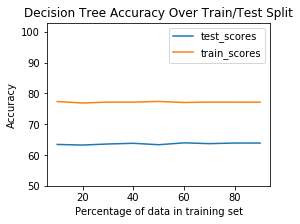

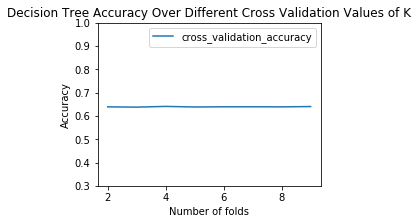

In [9]:
dt_model = DecisionTreeClassifier()
(dt_test_scores, dt_train_scores, dt_times, dt_cv_scores) = evaluate_model(big_df, dt_model, "Decision Tree")
optimal_test_split = dt_test_scores.index(max(dt_test_scores)) * 0.1
(dt_grid_train_x, dt_grid_train_y, dt_grid_test_x, dt_grid_test_y) = split_test_train(optimal_test_split, big_df)


dt_param_grid = {"criterion":["gini","entropy"], "max_depth":[x for x in range(2,31)], "min_samples_split":[3,5,7]}

dt_grid_results = GridSearchCV(dt_model, dt_param_grid, cv=5).fit(dt_grid_train_x, dt_grid_train_y)

In [10]:
print(confusion_matrix(dt_grid_test_y, dt_grid_results.predict(dt_grid_test_x)))
print("DT model accuracy:", metrics.accuracy_score(dt_grid_test_y, dt_grid_results.predict(dt_grid_test_x))) 
print("DT model precision:", metrics.precision_score(dt_grid_test_y, dt_grid_results.predict(dt_grid_test_x))) 
print("DT model recall:", metrics.recall_score(dt_grid_test_y, dt_grid_results.predict(dt_grid_test_x))) 

[[ 7767 10446]
 [ 1913 16242]]
DT model accuracy: 0.6601682798064232
DT model precision: 0.6085881294964028
DT model recall: 0.894629578628477


KNN test set scores: [64.97, 65.54, 65.53, 65.73, 65.81, 65.89, 65.43, 66.34, 64.94] 
KNN train set scores: [69.97, 68.56, 69.42, 69.53, 69.21, 69.58, 69.73, 69.39, 69.55]
KNN cross validation set scores: [(2, 0.6566820276497696), (3, 0.6570111915734036), (4, 0.658080974325214), (5, 0.6579741098310025), (6, 0.6584375685758174), (7, 0.658245556287031), (8, 0.6586707263550582), (9, 0.6586027328516151)]


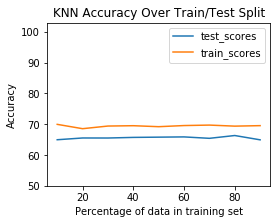

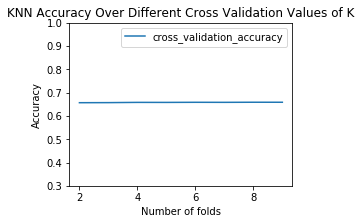

Best parameters found:
 {'n_neighbors': 50} with score of:  0.6674542434982108
[[3117 4156]
 [ 687 6545]]
Final KNN model accuracy: 0.6661151327128576
Final KNN model precision: 0.6116250817680591
Final KNN model recall: 0.9050055309734514


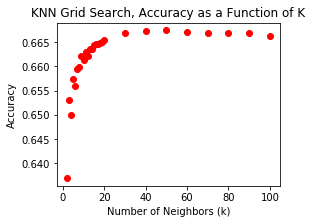

In [11]:
knn_classifier = KNeighborsClassifier()
evaluate_model(big_df, knn_classifier, "KNN")
knn_param_grid = {"n_neighbors":[x for x in range (2,21)] + [y*10 for y in range(3,11)]}
(knn_grid_train_x, knn_grid_train_y, knn_grid_test_x, knn_grid_test_y) = split_test_train(0.8, big_df)
knn_grid_results = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5).fit(knn_grid_train_x, knn_grid_train_y)

plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("KNN Grid Search, Accuracy as a Function of K")
knn_means = knn_grid_results.cv_results_['mean_test_score']
knn_stds = knn_grid_results.cv_results_['std_test_score']
knn_params = knn_grid_results.cv_results_['params']
k_vals = []
knn_accuracies = []
for mean, std, params in zip(knn_means, knn_stds, knn_params):
    knn_accuracies.append(mean)
    k_vals.append(params["n_neighbors"])
print('Best parameters found:\n', knn_grid_results.best_params_, "with score of: ", max(knn_grid_results.cv_results_['mean_test_score']))

    
eval_for_conclusion("KNN", knn_grid_results, knn_grid_test_x, knn_grid_test_y)

    
plt.plot(k_vals, knn_accuracies, 'o', color="red")
plt.show()    

C:\Users\nivetha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nivetha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nivetha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\nivetha\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: Fut

SVM test set scores: [66.87, 67.19, 67.4, 67.29, 67.42, 67.03, 66.82, 67.27, 67.08] 
SVM train set scores: [66.58, 67.11, 67.14, 67.44, 67.42, 67.68, 67.65, 67.52, 67.52]
SVM cross validation set scores: [(2, 0.6733322361202545), (3, 0.6738671274961597), (4, 0.6739905639675225), (5, 0.674130876418473), (6, 0.6743608733816107), (7, 0.6744020188720649), (8, 0.6743608733816107), (9, 0.6743891582596246)]


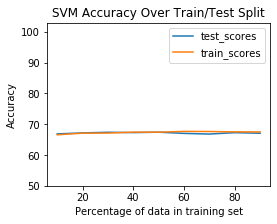

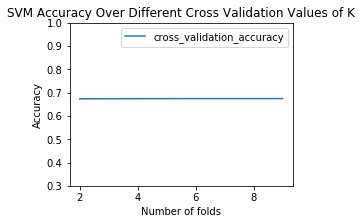

([66.87, 67.19, 67.4, 67.29, 67.42, 67.03, 66.82, 67.27, 67.08],
 [66.58, 67.11, 67.14, 67.44, 67.42, 67.68, 67.65, 67.52, 67.52],
 [2.9600682258605957,
  11.507206439971924,
  21.750330924987793,
  38.11216735839844,
  65.37176156044006,
  91.58168387413025,
  109.63184690475464,
  52.23491072654724,
  65.66928172111511],
 [(2, 0.6733322361202545),
  (3, 0.6738671274961597),
  (4, 0.6739905639675225),
  (5, 0.674130876418473),
  (6, 0.6743608733816107),
  (7, 0.6744020188720649),
  (8, 0.6743608733816107),
  (9, 0.6743891582596246)])

In [12]:
svm_classifier = svm.SVC()
evaluate_model(big_df, svm_classifier, "SVM")

In [13]:
svm_parameter_space = {
    'kernel': ['linear', 'rbf'],
    'C': [ float(i) / 100 for i in range (1, 300, 5)]+[5,7,9],    
}
svm_grid_clf = GridSearchCV(svm_classifier, svm_parameter_space, n_jobs=-1, cv=3)
(svm_train_x, svm_train_y, svm_test_x, svm_test_y) = split_test_train(0.1 * 8, big_df)
scaler = StandardScaler()
scaler.fit(svm_train_x)
svm_train_x = scaler.transform(svm_train_x)
svm_test_x = scaler.transform(svm_test_x)
svm_grid_clf.fit(svm_train_x, svm_train_y)

print("best params ", svm_grid_clf.best_params_)
svm_grid_score = svm_grid_clf.score(svm_test_x,svm_test_y)
print("SVM grid search model test set score: ", svm_grid_score)
print('Best SVM parameters found (cv):\n', svm_grid_clf.best_params_, "with score of: ", max(svm_grid_clf.cv_results_['mean_test_score']))


best params  {'C': 7, 'kernel': 'rbf'}
SVM grid search model test set score:  0.6682259063080416
Best SVM parameters found (cv):
 {'C': 7, 'kernel': 'rbf'} with score of:  0.6748436830835117


Adaboost test set scores: [66.16, 66.27, 66.55, 66.4, 66.33, 66.66, 66.47, 66.95, 66.52] 
Adaboost train set scores: [67.46, 66.96, 67.14, 66.95, 66.56, 66.59, 66.79, 66.7, 66.7]
Adaboost cross validation set scores: [(2, 0.6645408163265306), (3, 0.6651031380294053), (4, 0.6656654597322801), (5, 0.6657370375923908), (6, 0.6659260478384903), (7, 0.6653774412991004), (8, 0.6654734474434936), (9, 0.6658857217933623)]


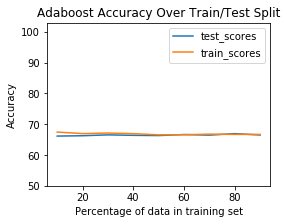

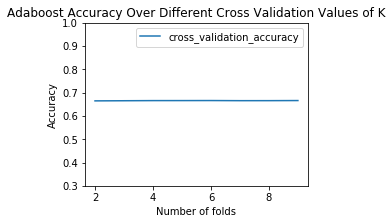

([66.16, 66.27, 66.55, 66.4, 66.33, 66.66, 66.47, 66.95, 66.52],
 [67.46, 66.96, 67.14, 66.95, 66.56, 66.59, 66.79, 66.7, 66.7],
 [0.1377561092376709,
  0.23365402221679688,
  0.34308314323425293,
  0.4144768714904785,
  0.5573961734771729,
  0.6802690029144287,
  0.7920377254486084,
  0.939457893371582,
  1.0853099822998047],
 [(2, 0.6645408163265306),
  (3, 0.6651031380294053),
  (4, 0.6656654597322801),
  (5, 0.6657370375923908),
  (6, 0.6659260478384903),
  (7, 0.6653774412991004),
  (8, 0.6654734474434936),
  (9, 0.6658857217933623)])

In [14]:
boost_classifier = AdaBoostClassifier()
evaluate_model(big_df, boost_classifier, "Adaboost")

In [15]:
boost_parameter_space = {
    'n_estimators': [i*10 for i in range(5,11)],
    'learning_rate': [ float(i) / 100 for i in range (1, 150, 10)]
}
boost_grid_clf = GridSearchCV(boost_classifier, boost_parameter_space, n_jobs=-1, cv=3)
(boost_train_x, boost_train_y, boost_test_x, boost_test_y) = split_test_train(0.1 * 8, big_df)
scaler = StandardScaler()
scaler.fit(boost_train_x)
boost_train_x = scaler.transform(boost_train_x)
boost_test_x = scaler.transform(boost_test_x)
boost_grid_clf.fit(boost_train_x, boost_train_y)

print("best Boost params ", boost_grid_clf.best_params_)
boost_grid_score = boost_grid_clf.score(boost_test_x,boost_test_y)
print("Bost grid search model test set score: ", boost_grid_score)
print('Best Boost parameters found through cv:\n', boost_grid_clf.best_params_, "with score of: ", max(boost_grid_clf.cv_results_['mean_test_score']))


best Boost params  {'learning_rate': 1.21, 'n_estimators': 100}
Bost grid search model test set score:  0.6680753775807122
Best Boost parameters found through cv:
 {'learning_rate': 1.21, 'n_estimators': 100} with score of:  0.6696193440268136


In [16]:
def plotting_func_boost(mean, params, plt, ax):
    x_var = "learning_rate"
    cmap = cm.hot
    norm = Normalize(vmin=-110, vmax=-20)
    ax.plot(params[x_var], mean,"o", color=cmap(norm(-1*params["n_estimators"])))
    
cmap = cm.hot
norm = Normalize(vmin=-110, vmax=-20)
yellow_patch = mpatches.Patch(color=cmap(norm(-50)), label='n_estimators=50')
red_patch = mpatches.Patch(color=cmap(norm(-80)), label='n_estimators=80')
black_patch = mpatches.Patch(color=cmap(norm(-110)), label='n_estimators=110')
handles = [yellow_patch, red_patch, black_patch] #[linear, rbf]#, red_patch, orange_patch, black_patch]


eval_for_conclusion("AdaBoosting", boost_grid_clf, boost_test_x, boost_test_y)

[[6463  762]
 [4029 3180]]
Final AdaBoosting model accuracy: 0.6680753775807122
Final AdaBoosting model precision: 0.806697108066971
Final AdaBoosting model recall: 0.44111527257594674


{'model': 'AdaBoosting',
 'recall': 0.44111527257594674,
 'accuracy': 0.6680753775807122,
 'precision': 0.806697108066971}

XGB test set scores: [66.1, 66.55, 66.57, 66.75, 67.06, 66.81, 67.0, 67.3, 67.46] 
XGB train set scores: [75.3, 73.05, 72.07, 70.95, 70.46, 70.37, 70.08, 69.78, 69.56]
XGB cross validation set scores: [(2, 0.6688062321702875), (3, 0.6699171604125521), (4, 0.6706577792407284), (5, 0.6699339682908458), (6, 0.6705480579328507), (7, 0.670465766951942), (8, 0.6710829493087558), (9, 0.6711798742981715)]


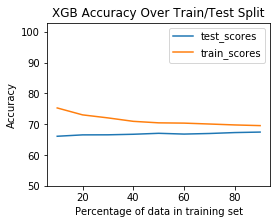

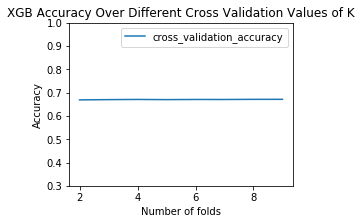

In [18]:
from xgboost import XGBClassifier
xg_model = XGBClassifier()
(xg_test_scores, xg_train_scores, xg_times, xg_cv_scores) = evaluate_model(big_df, xg_model, "XGB")
optimal_test_split = xg_test_scores.index(max(xg_test_scores)) * 0.1
(xg_grid_train_x, xg_grid_train_y, xg_grid_test_x, xg_grid_test_y) = split_test_train(optimal_test_split, big_df)


xg_param_grid = {"learning_rate":[0.01, 0.05, 0.1, 0.15, 0.2, 0.25], "n_estimator":[x for x in range(150,400,25)]}
xg_grid_results = GridSearchCV(xg_model, xg_param_grid, cv=5).fit(xg_grid_train_x, xg_grid_train_y)

In [19]:
print(confusion_matrix(xg_grid_test_y, xg_grid_results.predict(xg_grid_test_x)))
print("DT model accuracy:", metrics.accuracy_score(xg_grid_test_y, xg_grid_results.predict(xg_grid_test_x))) 
print("DT model precision:", metrics.precision_score(xg_grid_test_y, xg_grid_results.predict(xg_grid_test_x))) 
print("DT model recall:", metrics.recall_score(xg_grid_test_y, xg_grid_results.predict(xg_grid_test_x))) 

[[3262 4051]
 [ 752 6588]]
DT model accuracy: 0.6722172933870197
DT model precision: 0.6192311307453708
DT model recall: 0.8975476839237058


In [20]:
eval_df = pd.DataFrame(columns=["model", "accuracy", "recall", "precision"])
print("Confusion Matrix for Decision Tree")
eval_df = eval_df.append(eval_for_conclusion("Decision Tree", dt_grid_results, dt_grid_test_x, dt_grid_test_y), ignore_index=True)
print("\n\nConfusion Matrix for SVM")
eval_df = eval_df.append(eval_for_conclusion("SVM", svm_grid_clf, svm_test_x, svm_test_y), ignore_index=True)
print("\n\nConfusion Matrix for AdaBoosting")
eval_df = eval_df.append(eval_for_conclusion("AdaBoosting", boost_grid_clf, boost_test_x, boost_test_y), ignore_index=True)
print("\n\nConfusion Matrix for KNN")
eval_df = eval_df.append(eval_for_conclusion("KNN", knn_grid_results, knn_grid_test_x, knn_grid_test_y), ignore_index=True)
print("\n\nConfusion Matrix for XGB")
eval_df = eval_df.append(eval_for_conclusion("XGB", xg_grid_results, xg_grid_test_x, xg_grid_test_y), ignore_index=True)
eval_df.head()

Confusion Matrix for Decision Tree
[[ 7767 10446]
 [ 1913 16242]]
Final Decision Tree model accuracy: 0.6601682798064232
Final Decision Tree model precision: 0.6085881294964028
Final Decision Tree model recall: 0.894629578628477


Confusion Matrix for SVM
[[6494  717]
 [4106 3220]]
Final SVM model accuracy: 0.6682259063080416
Final SVM model precision: 0.8178816357632716
Final SVM model recall: 0.4395304395304395


Confusion Matrix for AdaBoosting
[[6463  762]
 [4029 3180]]
Final AdaBoosting model accuracy: 0.6680753775807122
Final AdaBoosting model precision: 0.806697108066971
Final AdaBoosting model recall: 0.44111527257594674


Confusion Matrix for KNN
[[3117 4156]
 [ 687 6545]]
Final KNN model accuracy: 0.6661151327128576
Final KNN model precision: 0.6116250817680591
Final KNN model recall: 0.9050055309734514


Confusion Matrix for XGB
[[3262 4051]
 [ 752 6588]]
Final XGB model accuracy: 0.6722172933870197
Final XGB model precision: 0.6192311307453708
Final XGB model recall: 0.8975

,model,accuracy,recall,precision
0,Decision Tree,0.660168,0.894630,0.608588
1,SVM,0.668226,0.439530,0.817882
2,AdaBoosting,0.668075,0.441115,0.806697
3,KNN,0.666115,0.905006,0.611625
4,XGB,0.672217,0.897548,0.619231
